In [1]:
# Modif target_binary, ignore_column for next participant ????????????????????????????
data_path = '..'
trial_info_file = '/data/A0/converted/trialinfo_matrix_A0_cleanedtrials.mat'
data_file = '/data/A0/Experimental/data.mat'
epoch_file = '/epochs_from_matrix/epochs_0.fif'

best_electrodes = ['Pz', 'P2', 'Oz', 'P1', 'POz', 'PO4']

# Dic to index trial_info matrix
info_colnames = {'0':0 ,'1':1 ,'RT':2,'PTB_check_RT_error':3, 'answer':4,'stimuli_target_interval':5,\
                      'base_delay':6, 'flicker_sides':7, 'cued_side':8, 'orients_L':9, 'orients_r':10,\
                      'ignore_column':11, 'target_angle':12, 'tagging_type':13, 'trial_number':14}

In [2]:
import scipy.io as sio
import scipy
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import EpochsTFRArray
import matplotlib.pyplot as plt
import copy
from collections import Counter


In [3]:
# Load trial info
f = sio.loadmat(f'{data_path}{trial_info_file}')
trial_info = f['all_info']


# Get target binary (i.e if a shift happened)
f = sio.loadmat(f'{data_path}{data_file}')
target_binary =f['data']['targets_binary'][0][0]
# Remove practice trials
target_binary = target_binary[1:,:]
# Collapse to trial indexes
original_shape = target_binary.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
target_binary = np.reshape(target_binary, new_shape)
target_binary = pd.DataFrame({'trial_number':np.arange(target_binary.shape[0]), 'target_binary':target_binary})

# Create pd df to pass to mne metadata
pd_info = pd.DataFrame(trial_info, columns=info_colnames.keys())
pd_info['trial_number']= pd_info['trial_number'].astype(int) - 1
pd_info = pd.merge(pd_info, target_binary, on = 'trial_number')

# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epochs.metadata = pd_info


Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1/notebooks/../epochs_from_matrix/epochs_0.fif ...


/tmp/ipykernel_19818/719731429.py:23: RuntimeWarning: This filename (../epochs_from_matrix/epochs_0.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f'{data_path}{epoch_file}')


    Found the data of interest:
        t =   -1000.00 ...    2299.32 ms
        0 CTF compensation matrices available
Not setting metadata
440 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 16 columns


In [4]:
# Keep only frequency tagging best electrodes
epochs.pick_channels(best_electrodes)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Number of events,440
Events,1: 440
Time range,-1.000 – 2.299 s
Baseline,off


In [5]:
# Keep only trials where there was no target
epochs = epochs['target_binary==0']

In [6]:
# Downsample EEG to tag sfreq
epochs.resample(480)

Number of events,360
Events,1: 360
Time range,-1.000 – 2.298 s
Baseline,off


# Noise tagging detection benchmark
## Inject noise to data

In [7]:
epochs_noistag = epochs['tagging_type==1'].copy()

f = sio.loadmat(f'{data_path}{data_file}')
noise_stims = f['data']['noise_stims'][0][0] # block x trial x sequences (L or R tag) x timepoints
# Filter out practice trials
noise_stims = noise_stims[1:,:,:,:]

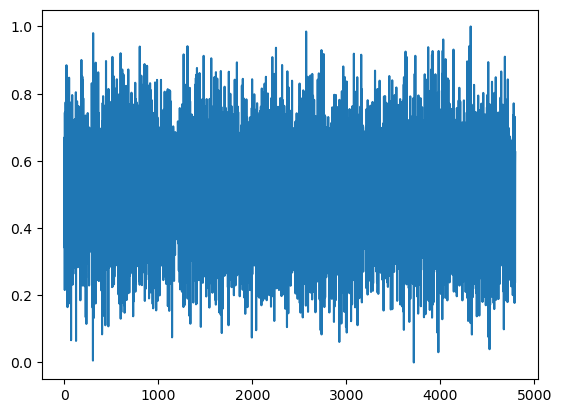

In [8]:
# First noise tag at block 15 trial 32
plt.plot(noise_stims[14,31,0,:].T)
# NB : tag 1 was always displayed on the left and tag 2 on the right

In [9]:
# Collapse to trial indexes
original_shape = noise_stims.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
noise_stims_tr = np.reshape(noise_stims, new_shape)

In [10]:
noise_stims_tr.shape

(480, 2, 4800)

In [11]:
# Inject to each EEG epoch its matching cued tag
buffer_arr = epochs_noistag.get_data()
# z-score EEG by electrode and trial
buffer_arr = (buffer_arr - np.mean(buffer_arr, axis=2, keepdims=True))/np.std(buffer_arr, axis=2, keepdims=True)
# After which sample from cue onset should the noise be in the data
offset = .1
for idx, trial in enumerate(epochs_noistag.metadata['trial_number']) :
    # Retrieve which tag was cued
    cued_side = int(epochs_noistag.metadata[epochs_noistag.metadata.trial_number == trial]['cued_side'])
    # Select the tag that was projected during the trial
    injected_tag = noise_stims_tr[trial, cued_side, \
        :int((np.abs(epochs_noistag.tmax)-offset)*epochs_noistag.info['sfreq'])+1]
    # z-score tag
    injected_tag = (injected_tag - np.mean(injected_tag))/np.std(injected_tag)
    # Relative magnitude of the tag in the EEG
    injected_tag *= .11111
    # Add the tag to the EEG
    buffer_arr[idx,:,int((np.abs(epochs_noistag.tmin)+offset)*epochs_noistag.info['sfreq']):] += injected_tag
epochs_noistag._data = buffer_arr

/tmp/ipykernel_19818/589320735.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  buffer_arr = epochs_noistag.get_data()
/tmp/ipykernel_19818/589320735.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cued_side = int(epochs_noistag.metadata[epochs_noistag.metadata.trial_number == trial]['cued_side'])


In [12]:
# Get cross-correlation 
def cross_cor_nois(epochs_fun, noise, display_side_cued_tag, sampling_freq, electrodes=None,
                  tmin_eeg=0, tmax_eeg=1, tmin_noise=0, tmax_noise=1):
    '''
    noise_tags : array trial*tag*timepoint
    display_side_cued_tag : 'left' or 'right'
    sampling_freq : 1920 or 480(Hz)
    tmin_noise : >=0
    
    Returns 2 matrices (trial*electrode*lag (in time steps between EEG start and tag start) of corr values. 
    The first matrice contains the EEG/cued_tag corr, the second the EEG/tag2 corr
    '''
    display_side_cued_tag = 0 if display_side_cued_tag == 'left' else \
        (1 if display_side_cued_tag == 'right' else ValueError("Invalid value for display_side_cued_tag"))

    # Select elec
    if electrodes is None : 
        eeg = epochs_fun.copy()
    else : eeg = epochs_fun.copy().pick(electrodes)
    noise_tags = copy.deepcopy(noise)
    # Converge EEG and tag sampling frequencies 
    if sampling_freq == 1920:
            eeg.resample(sfreq = sampling_freq)
            # Upsample tag from 480 to 1920Hz (by repetition rather than inference)
            noise_tags['data'] = np.repeat(noise_tags['data'], 4, axis=2)
    
    elif sampling_freq == 480:
        eeg.resample(sfreq = sampling_freq)
    
    else : raise ValueError('Sampling frequency must be 1920 or 480Hz')
    
    
    # bandpass (60-80Hz) EEG data + crop from tmin to tmax
    # Commented as bandpass filter reduces the crosscorrelation as assesed by injecting noise
    # eeg.filter(l_freq=60, h_freq = 80, verbose=False).crop(tmin_eeg, tmax_eeg)
    # crop EEG data from tmin to tmax
    eeg.filter(l_freq=60, h_freq = None, verbose=False).crop(tmin_eeg, tmax_eeg)
    
    selection = eeg[f'cued_side == {display_side_cued_tag}'].selection
    eeg_arr = eeg[f'cued_side == {display_side_cued_tag}'].get_data(copy=False)

    # Convert tmin/max noise to sample scale
    tmin_noise = int(tmin_noise * sampling_freq)
    tmax_noise = int(tmax_noise * sampling_freq)
    
    # Select the tags on the same trials as the EEG and only the part of between tmin_noise and tmax_noise
    # noise_tags = noise_tags['data'][np.isin(noise_tags['trial_number'], selection),:,tmin_noise:tmax_noise+1] 
    noise_tags = noise_tags[eeg.metadata['trial_number'][selection].values,:,tmin_noise:tmax_noise+1] 

    # Loop over trials and electrodes to fill correlation matrices
    # Cross correlation is done in valid mode so the resulting shape in samples/times is len(eeg) - len(noise) + 1
    cross_corr_tag1 = np.zeros((eeg_arr.shape[0], eeg_arr.shape[1], int(eeg_arr.shape[2]-noise_tags.shape[-1]+1)))
    cross_corr_tag2 = np.zeros((eeg_arr.shape[0], eeg_arr.shape[1], int(eeg_arr.shape[2]-noise_tags.shape[-1]+1)))
    
    for trial in range(eeg_arr.shape[0]):
        for elec in range(eeg_arr.shape[1]):
            # Standardize eeg trial data and noise
            trial_data = (eeg_arr[trial,elec,:]-eeg_arr[trial,elec,:].mean())/eeg_arr[trial,elec,:].std()
            trial_cuednoise = (noise_tags[trial,display_side_cued_tag,:]-noise_tags[trial,display_side_cued_tag,:].mean())\
                        /noise_tags[trial,display_side_cued_tag,:].std()
            trial_noncuednoise = (noise_tags[trial,1-display_side_cued_tag,:]-noise_tags[trial,1-display_side_cued_tag,:].mean())\
                        /noise_tags[trial,1-display_side_cued_tag,:].std()
            # Assume the tag can only appear in the EEG when its screen display has started (crop the first tag_length-1 outputs)
            cross_corr_tag1[trial, elec] = scipy.signal.correlate(trial_data, trial_cuednoise, \
                                                        mode='valid')
            cross_corr_tag2[trial, elec] = scipy.signal.correlate(trial_data, trial_noncuednoise, \
                                                        mode='valid')
    return cross_corr_tag1, cross_corr_tag2, selection, eeg.times[:-noise_tags.shape[-1]+1]


Sanitary check

(-10.0, 50.0)

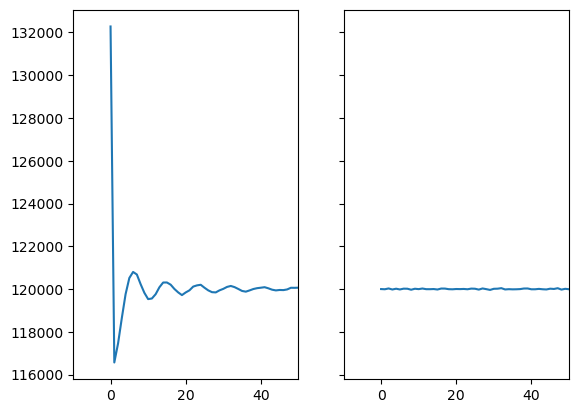

In [13]:
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)
ax[0].plot(np.mean(scipy.signal.correlate(noise_stims_tr[:,0], noise_stims_tr[:,0,:1000], \
                                                        mode='valid'),axis=0))
ax[1].plot(np.mean(scipy.signal.correlate(noise_stims_tr[:,0], noise_stims_tr[:,1,:1000], \
                                                        mode='valid'),axis=0))
plt.xlim(-10,50)

Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.


Text(0.5, 0.98, 'Cross-correlation time-series averaged across trials')

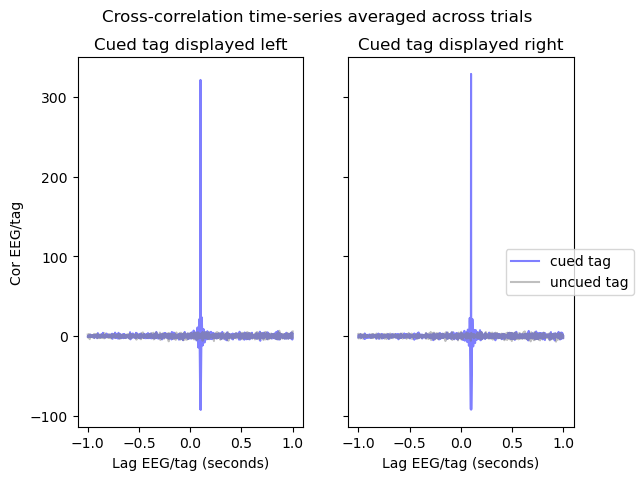

In [14]:
# Compute cross-cor on time-window ?????
sfreq = 480 # EEG and tag 
tmin_eeg, tmax_eeg = -1, 2
tmin_noise, tmax_noise = 0, 1


cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = \
    cross_cor_nois(epochs_fun = epochs_noistag, noise=noise_stims_tr, \
    display_side_cued_tag = 'right', electrodes = best_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise)

cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = \
    cross_cor_nois(epochs_noistag, noise_stims_tr, 'left', electrodes = best_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise)

# Plot
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].plot(times,cor_with_cued_for_cuedL.mean(axis=(0,1)).T, color='blue', alpha=.5)
ax[0].plot(times,cor_with_uncued_for_cuedL.mean(axis=(0,1)).T, color='grey', alpha=.5)

ax[1].plot(times,cor_with_cued_for_cuedR.mean(axis=(0,1)).T, color='blue', label='cued tag', alpha=.5)
ax[1].plot(times,cor_with_uncued_for_cuedR.mean(axis=(0,1)).T, color='grey', label='uncued tag', alpha=.5)


ax[0].set_title('Cued tag displayed left');
ax[1].set_title('Cued tag displayed right');

ax[1].legend(bbox_to_anchor = (1.3,0.5))
ax[0].set_xlabel('Lag EEG/tag (seconds)')
ax[1].set_xlabel('Lag EEG/tag (seconds)')
ax[0].set_ylabel('Cor EEG/tag')
plt.suptitle('Cross-correlation time-series averaged across trials')

Text(0.5, 0.98, 'Cross-correlation time-series averaged across trials (zoom)')

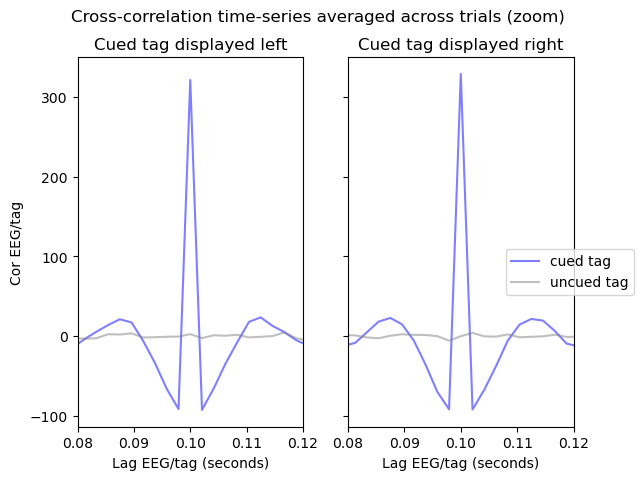

In [15]:
# Plot
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].plot(times,cor_with_cued_for_cuedL.mean(axis=(0,1)).T, color='blue', alpha=.5)
ax[0].plot(times,cor_with_uncued_for_cuedL.mean(axis=(0,1)).T, color='grey', alpha=.5)

ax[1].plot(times,cor_with_cued_for_cuedR.mean(axis=(0,1)).T, color='blue', label='cued tag', alpha=.5)
ax[1].plot(times,cor_with_uncued_for_cuedR.mean(axis=(0,1)).T, color='grey', label='uncued tag', alpha=.5)


ax[0].set_title('Cued tag displayed left');
ax[1].set_title('Cued tag displayed right');

ax[1].legend(bbox_to_anchor = (1.3,0.5))
ax[0].set_xlabel('Lag EEG/tag (seconds)')
ax[1].set_xlabel('Lag EEG/tag (seconds)')
ax[0].set_ylabel('Cor EEG/tag')
plt.xlim(0.08,0.12)
plt.suptitle('Cross-correlation time-series averaged across trials (zoom)')

### 1.1.1 Comparing pre and post cue crosscorrelation

Test for cued tag and electrode Pz: TtestResult(statistic=74.3252576605553, pvalue=3.2725720961165135e-133, df=173)
Test for uncued tag and electrode Pz: TtestResult(statistic=8.595494483877978, pvalue=4.777554992889852e-15, df=173)
Test for cued tag and electrode P2: TtestResult(statistic=76.54649874096089, pvalue=2.329888197561549e-135, df=173)
Test for uncued tag and electrode P2: TtestResult(statistic=7.993188844951696, pvalue=1.7901510342995417e-13, df=173)
Test for cued tag and electrode Oz: TtestResult(statistic=37.86620810316975, pvalue=1.2046314909475985e-85, df=173)
Test for uncued tag and electrode Oz: TtestResult(statistic=5.147889129456098, pvalue=7.103798118435136e-07, df=173)
Test for cued tag and electrode P1: TtestResult(statistic=68.0731580662024, pvalue=7.932044694836258e-127, df=173)
Test for uncued tag and electrode P1: TtestResult(statistic=9.31603182607476, pvalue=5.51982627050759e-17, df=173)
Test for cued tag and electrode POz: TtestResult(statistic=69.76078966

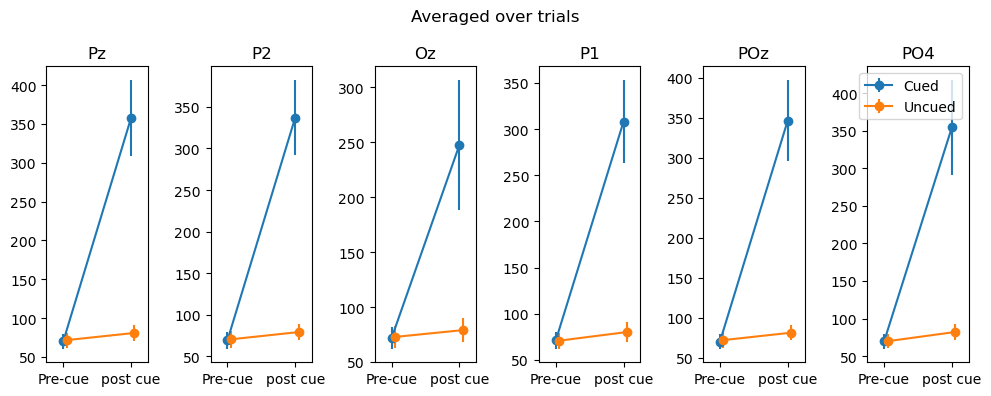

In [16]:
cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])

fig, ax = plt.subplots(1,6, figsize=(10,4), sharex=True)
for i, elec in enumerate(best_electrodes):
    max_precue_cued = cor_with_cued[:,i,:cor_with_cued.shape[-1]//2].max(axis=-1)
    max_postcue_cued = cor_with_cued[:,i,cor_with_cued.shape[-1]//2-1:].max(axis=-1)
    ax[i].errorbar(x=[0,1], y=[np.mean(max_precue_cued), np.mean(max_postcue_cued)],
                    yerr=[np.std(max_precue_cued), np.std(max_postcue_cued)], fmt='o-', label='Cued')
    print(f'Test for cued tag and electrode {elec}: {scipy.stats.ttest_rel(max_postcue_cued, max_precue_cued)}')
    max_precue_uncued = cor_with_uncued[:,i,:cor_with_uncued.shape[-1]//2].max(axis=-1)
    max_postcue_uncued = cor_with_uncued[:,i,cor_with_uncued.shape[-1]//2-1:].max(axis=-1)
    
    ax[i].errorbar([0.05,1.05], [np.mean(max_precue_uncued), np.mean(max_postcue_uncued)],
                    [np.std(max_precue_uncued), np.std(max_postcue_uncued)], fmt='o-', label='Uncued')
    print(f'Test for uncued tag and electrode {elec}: {scipy.stats.ttest_rel(max_postcue_uncued,max_precue_uncued)}')
                        
    ax[i].set_xticks([0,1],['Pre-cue', 'post cue'])
    ax[i].set_title(elec)
ax[-1].legend()
plt.xlim(-.25, 1.25)
plt.suptitle('Averaged over trials')
plt.tight_layout()


Instead of doing it per electrode we can, prior to looking for the max, average across electrodes to improve SNR

Test for cued tag: TtestResult(statistic=87.31720247146343, pvalue=5.308181026217845e-145, df=173)
Test for uncued tag: TtestResult(statistic=13.162951280130944, pvalue=7.286612762804934e-28, df=173)


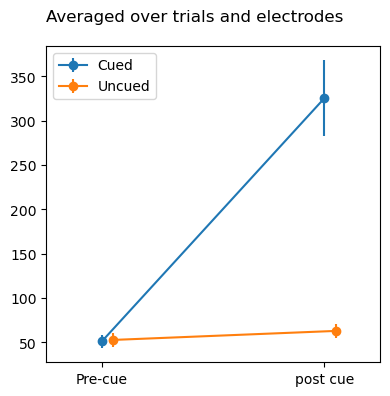

In [17]:
cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])

fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True)
max_precue_cued = cor_with_cued[:,:,:cor_with_cued.shape[-1]//2].mean(axis=1).max(axis=-1)
max_postcue_cued = cor_with_cued[:,:,cor_with_cued.shape[-1]//2-1:].mean(axis=1).max(axis=-1)
ax.errorbar(x=[0,1], y=[np.mean(max_precue_cued), np.mean(max_postcue_cued)],
                yerr=[np.std(max_precue_cued), np.std(max_postcue_cued)], fmt='o-', label='Cued')
print(f'Test for cued tag: {scipy.stats.ttest_rel(max_postcue_cued, max_precue_cued)}')
max_precue_uncued = cor_with_uncued[:,:,:cor_with_uncued.shape[-1]//2].mean(axis=1).max(axis=-1)
max_postcue_uncued = cor_with_uncued[:,:,cor_with_uncued.shape[-1]//2-1:].mean(axis=1).max(axis=-1)

ax.errorbar([0.05,1.05], [np.mean(max_precue_uncued), np.mean(max_postcue_uncued)],
                [np.std(max_precue_uncued), np.std(max_postcue_uncued)], fmt='o-', label='Uncued')
print(f'Test for uncued tag: {scipy.stats.ttest_rel(max_postcue_uncued,max_precue_uncued)}')
                    
ax.set_xticks([0,1],['Pre-cue', 'post cue'])
ax.legend()
plt.xlim(-.25, 1.25)
plt.suptitle('Averaged over trials and electrodes')
plt.tight_layout()


In [18]:
crosscor_prepost = {}
crosscor_prepost['cued_pre'] = cor_with_cued[:,:,:cor_with_cued.shape[-1]//2+1].mean(axis=1).max(axis=-1)
crosscor_prepost['cued_post'] = cor_with_cued[:,:,cor_with_cued.shape[-1]//2:].mean(axis=1).max(axis=-1)
crosscor_prepost['uncued_pre'] = cor_with_uncued[:,:,:cor_with_uncued.shape[-1]//2+1].mean(axis=1).max(axis=-1)
crosscor_prepost['uncued_post'] = cor_with_uncued[:,:,cor_with_uncued.shape[-1]//2:].mean(axis=1).max(axis=-1)
crosscor_prepost['uncued_post'] 
crosscor_prepost_df = pd.DataFrame(crosscor_prepost)
crosscor_prepost_df = crosscor_prepost_df.melt()
crosscor_prepost_df[['cued', 'prepost']] = crosscor_prepost_df['variable'].str.split('_', expand=True)
crosscor_prepost_df = crosscor_prepost_df.drop('variable', axis=1)
crosscor_prepost_df.to_csv('files/A0_crosscor_prepost_inject_noise.csv',index=False)
crosscor_prepost_df

,value,cued,prepost
0,55.007425,cued,pre
1,53.169557,cued,pre
2,45.739277,cued,pre
3,44.212893,cued,pre
4,60.894982,cued,pre
...,...,...,...
691,73.812682,uncued,post
692,74.327999,uncued,post
693,63.998064,uncued,post
694,57.496063,uncued,post


S'il y avait un effet attentionel on attendrait que seulement le cued augmente, s'il n'y a pas d'effet attentionnel mais que les tags sont present on peut attendre que les deux tags augmentent. Si les tags ne sont pas present, le post-cue n'est pas superieur au pre-cue

In [19]:
# # Export for group analysis
# def prepostcor_todf(corr_arr, time_window, tag_cueing):
#     df = pd.DataFrame(corr_arr, columns = ['max_avg_over_ch_crosscor'])
#     df['pre/post_cue'] = time_window
#     df['cued/uncued_tag'] = tag_cueing
#     return df


# prepostcue_cor_A0 = pd.concat([prepostcor_todf(max_postcue_cued, 'postcue', 'cued'), prepostcor_todf(max_postcue_uncued, 'postcue', 'uncued'),  \
#            prepostcor_todf(max_precue_cued, 'precue', 'cued'), prepostcor_todf(max_precue_uncued, 'precue', 'uncued')    ])

# prepostcue_cor_A0.to_csv('files/prepostcue_cor_A0.csv',index=False)


### 1.1.2 Comparing cross-correlation on displayed trial vs others

In [20]:
sfreq = 480 # EEG and tag 
tmin_eeg, tmax_eeg = -1, 2 # Take up to two seconds to allow for max correlation even after stimulus onset
tmin_noise, tmax_noise = 0, 1

# First for left cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 0'].selection]
# (cued, uncued), trial, elec, time
trial_crosscorr_matL = np.zeros((2, len(trials), len(trials), len(best_electrodes), tmax_eeg*sfreq+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[trial], (len(noise_stims_tr),1, 1))
    # Give the same trial number as the EEG
    # Perform cross-correlation on the repeated noise and all eeg trials
    crosscorr_trial = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'left', electrodes = best_electrodes,\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    trial_crosscorr_matL[0, trial_idx] = crosscorr_trial[0]
    trial_crosscorr_matL[1, trial_idx] = crosscorr_trial[1]

# For right cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 1'].selection]
trial_crosscorr_matR = np.zeros((2, len(trials), len(trials), len(best_electrodes), tmax_eeg*sfreq+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[ trial], (len(noise_stims_tr),1, 1))
    # Give the same trial number as the EEG
    # Perform cross-correlation on the repeated noise and all eeg trials
    crosscorr_trial = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'right', electrodes = best_electrodes,\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    trial_crosscorr_matR[0, trial_idx] = crosscorr_trial[0]
    trial_crosscorr_matR[1, trial_idx] = crosscorr_trial[1]

Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the

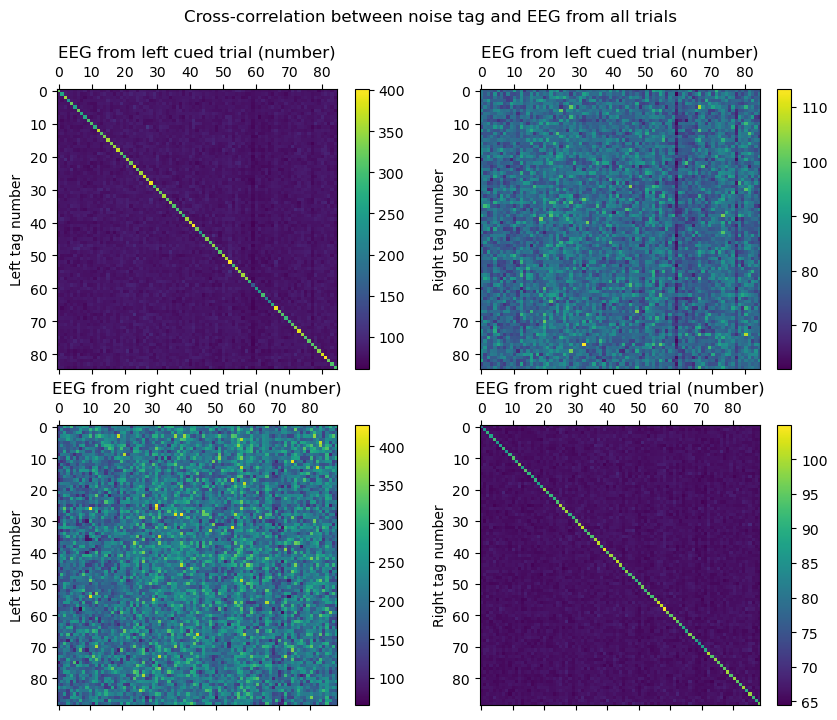

In [21]:
fig, ax = plt.subplots(2,2, figsize=(10,8))
noise1 = ax[0,0].matshow(np.mean(trial_crosscorr_matL[0][:,:,:,trial_crosscorr_matL.shape[-1]//2:].max(axis=-1), axis=-1))
fig.colorbar(noise1, ax=ax[0,0])
ax[0,0].set_ylabel('Left tag number')
ax[0,0].set_title('EEG from left cued trial (number)')
noise2 = ax[0,1].matshow(np.mean(trial_crosscorr_matL[1][:,:,:,trial_crosscorr_matL.shape[-1]//2:].max(axis=-1), axis=-1))
fig.colorbar(noise2, ax=ax[0,1])
ax[0,1].set_ylabel('Right tag number')
ax[0,1].set_title('EEG from left cued trial (number)')
noise2 = ax[1,0].matshow(np.mean(trial_crosscorr_matR[1][:,:,:,trial_crosscorr_matL.shape[-1]//2:].max(axis=-1), axis=-1))
fig.colorbar(noise2, ax=ax[1,1])
ax[1,0].set_ylabel('Left tag number')
ax[1,0].set_title('EEG from right cued trial (number)')
noise1 = ax[1,1].matshow(np.mean(trial_crosscorr_matR[0][:,:,:,trial_crosscorr_matL.shape[-1]//2:].max(axis=-1), axis=-1))
fig.colorbar(noise1, ax=ax[1,0])
ax[1,1].set_ylabel('Right tag number')
ax[1,1].set_title('EEG from right cued trial (number)')

plt.suptitle('Cross-correlation between noise tag and EEG from all trials')
plt.show()


Effective window size : 0.533 (s)
Effective window size : 0.533 (s)


/tmp/ipykernel_19818/241780162.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


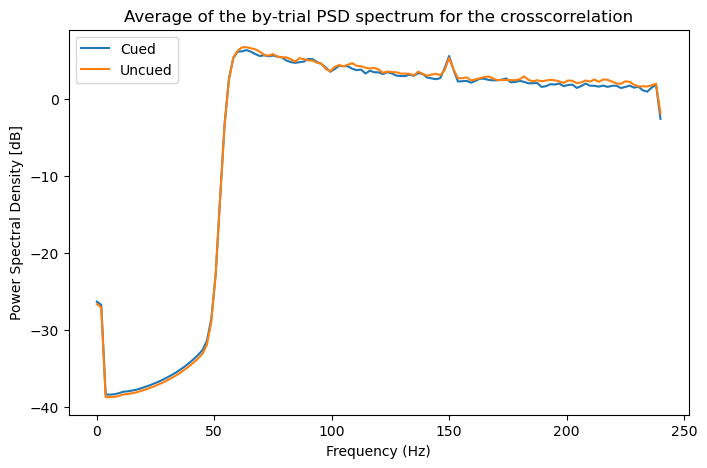

In [22]:
cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])

psds, freqs_psd = mne.time_frequency.psd_array_welch(cor_with_cued, sfreq=sfreq)

fig, axes = plt.subplots(1, 1, sharex="all", sharey="none", figsize=(8, 5))

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0,1))
axes.plot(freqs_psd, psds_mean, label='Cued')

psds, freqs_psd = mne.time_frequency.psd_array_welch(cor_with_uncued, sfreq=sfreq)


psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0,1))
axes.plot(freqs_psd, psds_mean, label='Uncued')
axes.set(title="Average of the by-trial PSD spectrum for the crosscorrelation", ylabel="Power Spectral Density [dB]")
plt.xlabel('Frequency (Hz)')
plt.legend()
fig.show()
